In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn


/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Latent Space from training

In [3]:
config = pickle.load(open('RUNS/2022-07-15@11:41:09-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-07-15@11:41:09-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))

In [4]:
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.
loading best_loss.pt at epoch 9...


In [4]:
data_sample, mu_stack = trainer.train(dataset.get_loader(), epoch + 1)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.
loading best_loss.pt at epoch 9...
Data loaded. Size: 1090461. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


64
Epoch loss:  0.17289263010025024
len:  34077
Dataset: <class 'tuple'>
96
Epoch loss:  0.4078162908554077
len:  34077
Dataset: <class 'tuple'>
128
Epoch loss:  0.5805893093347549
len:  34077
Dataset: <class 'tuple'>
160
Epoch loss:  0.8800695985555649
len:  34077
Dataset: <class 'tuple'>
192
Epoch loss:  1.1888530403375626
len:  34077
Dataset: <class 'tuple'>
224
Epoch loss:  1.5157525092363358
len:  34077
Dataset: <class 'tuple'>
256
Epoch loss:  1.7229757755994797
len:  34077
Dataset: <class 'tuple'>
288
Epoch loss:  1.960098534822464
len:  34077
Dataset: <class 'tuple'>
320
Epoch loss:  2.160068765282631
len:  34077
Dataset: <class 'tuple'>
352
Epoch loss:  2.4088552743196487
len:  34077
Dataset: <class 'tuple'>
384
Epoch loss:  2.6935195177793503
len:  34077
Dataset: <class 'tuple'>
416
Epoch loss:  2.835120916366577
len:  34077
Dataset: <class 'tuple'>
448
Epoch loss:  3.150307983160019
len:  34077
Dataset: <class 'tuple'>
480
Epoch loss:  3.316389635205269
len:  34077
Dataset: 

Epoch loss:  27.242286764085293
len:  34077
Dataset: <class 'tuple'>
3680
Epoch loss:  27.445202223956585
len:  34077
Dataset: <class 'tuple'>
3712
Epoch loss:  27.634848915040493
len:  34077
Dataset: <class 'tuple'>
3744
Epoch loss:  27.973315499722958
len:  34077
Dataset: <class 'tuple'>
3776
Epoch loss:  28.1959111019969
len:  34077
Dataset: <class 'tuple'>
3808
Epoch loss:  28.423507653176785
len:  34077
Dataset: <class 'tuple'>
3840
Epoch loss:  28.612421549856663
len:  34077
Dataset: <class 'tuple'>
3872
Epoch loss:  28.821154482662678
len:  34077
Dataset: <class 'tuple'>
3904
Epoch loss:  28.984826751053333
len:  34077
Dataset: <class 'tuple'>
3936
Epoch loss:  29.151772387325764
len:  34077
Dataset: <class 'tuple'>
3968
Epoch loss:  29.343397699296474
len:  34077
Dataset: <class 'tuple'>
4000
Epoch loss:  29.46850637346506
len:  34077
Dataset: <class 'tuple'>
4032
Epoch loss:  29.56354756653309
len:  34077
Dataset: <class 'tuple'>
4064
Epoch loss:  29.809740766882896
len:  3407

Epoch loss:  52.68371531367302
len:  34077
Dataset: <class 'tuple'>
7264
Epoch loss:  52.899058654904366
len:  34077
Dataset: <class 'tuple'>
7296
Epoch loss:  53.12840047478676
len:  34077
Dataset: <class 'tuple'>
7328
Epoch loss:  53.31436009705067
len:  34077
Dataset: <class 'tuple'>
7360
Epoch loss:  53.513392210006714
len:  34077
Dataset: <class 'tuple'>
7392
Epoch loss:  53.79151776432991
len:  34077
Dataset: <class 'tuple'>
7424
Epoch loss:  53.979029819369316
len:  34077
Dataset: <class 'tuple'>
7456
Epoch loss:  54.23101417720318
len:  34077
Dataset: <class 'tuple'>
7488
Epoch loss:  54.40046267211437
len:  34077
Dataset: <class 'tuple'>
7520
Epoch loss:  54.61808027327061
len:  34077
Dataset: <class 'tuple'>
7552
Epoch loss:  54.90964566171169
len:  34077
Dataset: <class 'tuple'>
7584
Epoch loss:  55.24100239574909
len:  34077
Dataset: <class 'tuple'>
7616
Epoch loss:  55.4862712174654
len:  34077
Dataset: <class 'tuple'>
7648
Epoch loss:  55.6717010140419
len:  34077
Dataset

In [7]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [16]:
dataset.data.iloc[data_sample_index].logP.to_numpy()

array([3.92612, 4.1662 , 1.0295 , ..., 3.11182, 3.7222 , 4.64287])

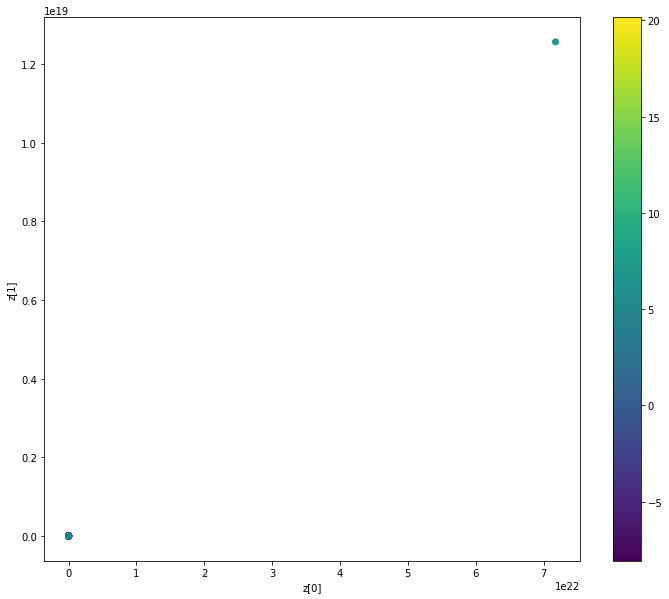

In [43]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:9984, 0].detach().numpy(), mu_stack[:9984, 1].detach().numpy(), c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0008, 0.0008)
#plt.ylim(-0.0009, 0.0009)
plt.show()

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = mu_stack[:9984].detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

In [41]:
principalDf

,pc1,pc2,pc3
0,-0.077090,-0.050692,0.017952
1,-0.077132,-0.052495,0.017956
2,-0.077131,-0.052482,0.017941
3,-0.077131,-0.052482,0.017957
4,-0.077131,-0.052482,0.017955
...,...,...,...
9979,-0.077164,-0.052512,-0.798874
9980,-0.077159,-0.052507,-0.748614
9981,-0.077160,-0.052508,-0.803975
9982,-0.077160,-0.052508,-0.865643


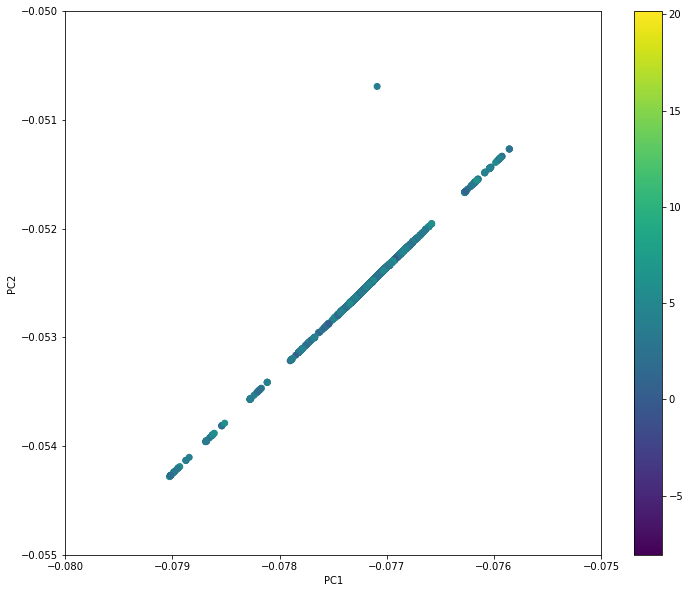

In [42]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.xlim(-0.08, -0.075)
plt.ylim(-0.055, -0.05)
plt.show()

In [5]:
def get_optimizer(config, model):
    return Adam(model.parameters(), lr=config.get('optim_lr'))


def get_scheduler(config, optimizer):
    return StepLR(optimizer,
                  step_size=config.get('sched_step_size'),
                  gamma=config.get('sched_gamma'))

In [6]:
model = Frag2Mol(config, vocab)
optimizer = get_optimizer(config, model)
scheduler = get_scheduler(config, optimizer)
criterion = Loss(config, pad=vocab.PAD)
model = model.cuda()
losses = []
best_loss = np.float('inf')
scores = []
best_score = - np.float('inf')

<ipython-input-6-1785cb37f18f>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_loss = np.float('inf')
<ipython-input-6-1785cb37f18f>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_score = - np.float('inf')


In [7]:
model

Frag2Mol(
  (embedder): Embedding(90175, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=90175, bias=True)
  )
)

In [8]:
batch = next(iter(dataset.get_loader()))

Data loaded. Size: 1090461. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
device = torch.device('cpu')
src = batch[0].to(device)
tgt = batch[1]
lengths = batch[2]
index = batch[3]

In [10]:
device

device(type='cpu')

In [17]:
model = model.to(device)

In [100]:
yhat = model(Variable(src), lengths)

In [30]:
logP = dataset.data.iloc[list(index)].logP.to_numpy()

In [15]:
output, mu, sigma = model.forward(Variable(src), lengths)

In [19]:
mu.size()

torch.Size([32, 100])

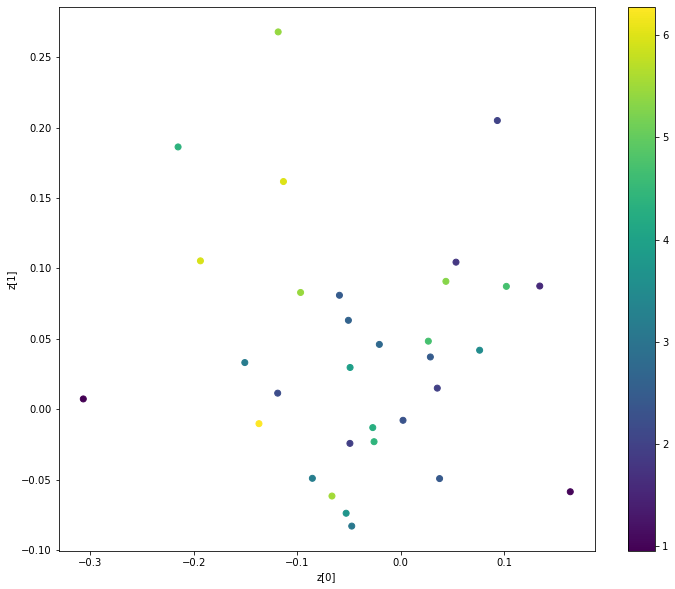

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter(mu[:, 0].detach().numpy(), mu[:, 1].detach().numpy(), c = logP)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()

# Plot Latent Space

In [16]:
config = pickle.load(open('RUNS/2022-08-08@17:35:48-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-08-08@17:35:48-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
device = torch.device('cuda')
model = model.to(device)

Vocab created/loaded. Size: 70458. Effective size: 70458. Time elapsed: 00:00:00.


In [17]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 4...


In [18]:
model

Frag2Mol(
  (embedder): Embedding(70458, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=70458, bias=True)
  )
)

In [19]:
loader = dataset.get_loader()
data_sample = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 62961. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
rnn2mean_weight

Parameter containing:
tensor([[ 0.0839, -0.0753,  0.0272,  ..., -0.0466,  0.0224, -0.0500],
        [ 0.0482, -0.0460,  0.0486,  ..., -0.0498, -0.0513,  0.0776],
        [ 0.0254, -0.0825, -0.0445,  ..., -0.0323,  0.0110,  0.0656],
        ...,
        [-0.0418, -0.0041, -0.0458,  ...,  0.1031,  0.0739, -0.0353],
        [ 0.0699, -0.0718,  0.0851,  ..., -0.0697, -0.0297, -0.0576],
        [-0.0354, -0.0544,  0.0775,  ...,  0.0817, -0.0003,  0.0202]],
       device='cuda:0', requires_grad=True)

In [21]:
for idx, (src, tgt, lengths, data) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z = model.forward(src, lengths)
    
    print(torch.all(rnn2mean_weight == model.encoder.rnn2mean.weight))
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
    print(len(mu_stack))
    if len(mu_stack) > 10000:
        break

tensor(True, device='cuda:0')
32
tensor(True, device='cuda:0')
64
tensor(True, device='cuda:0')
96
tensor(True, device='cuda:0')
128
tensor(True, device='cuda:0')
160
tensor(True, device='cuda:0')
192
tensor(True, device='cuda:0')
224
tensor(True, device='cuda:0')
256
tensor(True, device='cuda:0')
288
tensor(True, device='cuda:0')
320
tensor(True, device='cuda:0')
352
tensor(True, device='cuda:0')
384
tensor(True, device='cuda:0')
416
tensor(True, device='cuda:0')
448
tensor(True, device='cuda:0')
480
tensor(True, device='cuda:0')
512
tensor(True, device='cuda:0')
544
tensor(True, device='cuda:0')
576
tensor(True, device='cuda:0')
608
tensor(True, device='cuda:0')
640
tensor(True, device='cuda:0')
672
tensor(True, device='cuda:0')
704
tensor(True, device='cuda:0')
736
tensor(True, device='cuda:0')
768
tensor(True, device='cuda:0')
800
tensor(True, device='cuda:0')
832
tensor(True, device='cuda:0')
864
tensor(True, device='cuda:0')
896
tensor(True, device='cuda:0')
928
tensor(True, devi

tensor(True, device='cuda:0')
7936
tensor(True, device='cuda:0')
7968
tensor(True, device='cuda:0')
8000
tensor(True, device='cuda:0')
8032
tensor(True, device='cuda:0')
8064
tensor(True, device='cuda:0')
8096
tensor(True, device='cuda:0')
8128
tensor(True, device='cuda:0')
8160
tensor(True, device='cuda:0')
8192
tensor(True, device='cuda:0')
8224
tensor(True, device='cuda:0')
8256
tensor(True, device='cuda:0')
8288
tensor(True, device='cuda:0')
8320
tensor(True, device='cuda:0')
8352
tensor(True, device='cuda:0')
8384
tensor(True, device='cuda:0')
8416
tensor(True, device='cuda:0')
8448
tensor(True, device='cuda:0')
8480
tensor(True, device='cuda:0')
8512
tensor(True, device='cuda:0')
8544
tensor(True, device='cuda:0')
8576
tensor(True, device='cuda:0')
8608
tensor(True, device='cuda:0')
8640
tensor(True, device='cuda:0')
8672
tensor(True, device='cuda:0')
8704
tensor(True, device='cuda:0')
8736
tensor(True, device='cuda:0')
8768
tensor(True, device='cuda:0')
8800
tensor(True, device=

In [22]:
data_sample_index = [item for sublist in data_sample for item in sublist]

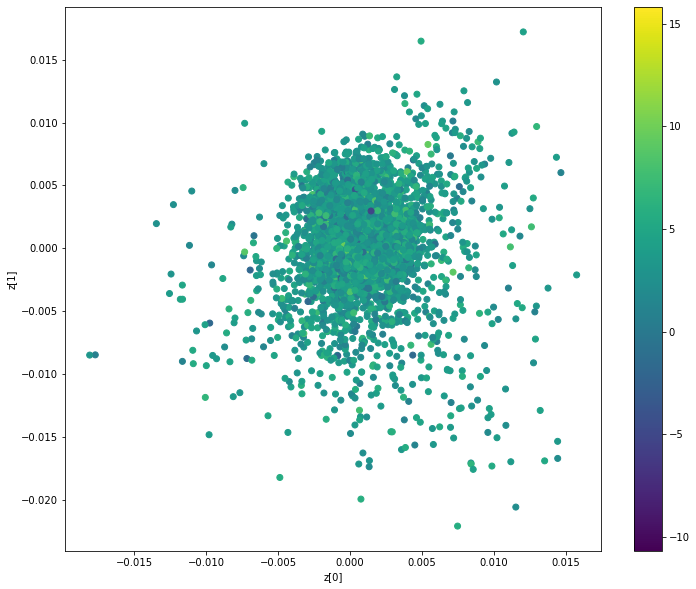

In [23]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 0].cpu().detach().numpy(), mu_stack[:, 1].cpu().detach().numpy(), c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [47]:
mu_stack

tensor([[ 1.4013e-45,  0.0000e+00,  5.1844e+22,  ...,  3.0803e-41,
          5.1842e+22,  3.0803e-41],
        [ 5.1843e+22,  3.0803e-41,  2.8026e-45,  ...,  1.3563e-19,
          4.7431e+30,  1.7466e+19],
        [ 2.9087e+32,  1.7220e+22,  1.6020e-19,  ...,  7.1831e+22,
          1.6879e+25,  5.7010e-13],
        ...,
        [-1.0938e-03, -1.0665e-03, -9.9152e-04,  ...,  1.0645e-03,
          1.0949e-03, -9.5291e-04],
        [-1.0242e-03, -1.0672e-03, -9.7669e-04,  ...,  1.0509e-03,
          9.8428e-04, -9.2889e-04],
        [-1.2658e-03, -1.2170e-03, -1.0745e-03,  ...,  1.1769e-03,
          1.1500e-03, -1.0849e-03]], device='cuda:0', grad_fn=<CatBackward0>)

# Predict property with MLP

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [9]:
data = dataset.data.iloc[data_index_lst_final]

In [10]:
labels = torch.tensor(data.logP.values)

In [11]:
MLP_model = MLP()

In [12]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.01)
#loss_fn = F.mse_loss()
latent_output_data = F.normalize(mu_stack)

In [13]:
latent_output_data

tensor([[-0.0971,  0.2228,  0.1126,  ..., -0.1734,  0.1321, -0.0438],
        [ 0.0984,  0.0698,  0.0571,  ..., -0.1173,  0.0291,  0.0240],
        [ 0.0180,  0.1795,  0.1068,  ..., -0.2311,  0.1422, -0.0171],
        ...,
        [-0.0611,  0.2913, -0.0421,  ...,  0.0511,  0.1175, -0.0594],
        [-0.0783, -0.2119,  0.2113,  ..., -0.1053,  0.1030, -0.0937],
        [-0.1006,  0.2768, -0.2372,  ...,  0.0556, -0.1222, -0.0177]],
       grad_fn=<DivBackward0>)

In [14]:
F.normalize(mu_stack)

tensor([[-0.0971,  0.2228,  0.1126,  ..., -0.1734,  0.1321, -0.0438],
        [ 0.0984,  0.0698,  0.0571,  ..., -0.1173,  0.0291,  0.0240],
        [ 0.0180,  0.1795,  0.1068,  ..., -0.2311,  0.1422, -0.0171],
        ...,
        [-0.0611,  0.2913, -0.0421,  ...,  0.0511,  0.1175, -0.0594],
        [-0.0783, -0.2119,  0.2113,  ..., -0.1053,  0.1030, -0.0937],
        [-0.1006,  0.2768, -0.2372,  ...,  0.0556, -0.1222, -0.0177]],
       grad_fn=<DivBackward0>)

In [15]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 20

for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = F.mse_loss(outputs.type(torch.float64), labels[i])
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())                
        if i == 0 or i % 1000 == 0:
            print("Prediction: ", outputs, ", Label: ", labels[i])
            print("Batch Predictor loss: ", np.mean(train_losses))
            
    MLP_model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

<ipython-input-15-a239eac746e6>:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.type(torch.float64), labels[i])


Prediction:  tensor([-0.0247], grad_fn=<AddBackward0>) , Label:  tensor(2.3340, dtype=torch.float64)
Batch Predictor loss:  5.563410644731053
Prediction:  tensor([4.8602], grad_fn=<AddBackward0>) , Label:  tensor(4.1112, dtype=torch.float64)
Batch Predictor loss:  4.589000453345822
Prediction:  tensor([3.8275], grad_fn=<AddBackward0>) , Label:  tensor(1.3383, dtype=torch.float64)
Batch Predictor loss:  4.100185669159366
Prediction:  tensor([3.5037], grad_fn=<AddBackward0>) , Label:  tensor(0.8056, dtype=torch.float64)
Batch Predictor loss:  3.848619270831735
Prediction:  tensor([3.6488], grad_fn=<AddBackward0>) , Label:  tensor(4.5608, dtype=torch.float64)
Batch Predictor loss:  3.6254573675455863
Prediction:  tensor([3.2320], grad_fn=<AddBackward0>) , Label:  tensor(2.7636, dtype=torch.float64)
Batch Predictor loss:  3.526091047615303
Prediction:  tensor([3.5041], grad_fn=<AddBackward0>) , Label:  tensor(3.9494, dtype=torch.float64)
Batch Predictor loss:  3.4816670907495033
Prediction

KeyboardInterrupt: 

In [43]:
latent_data.size()

torch.Size([100])

In [32]:
labels[i]

tensor(0.9203, dtype=torch.float64)

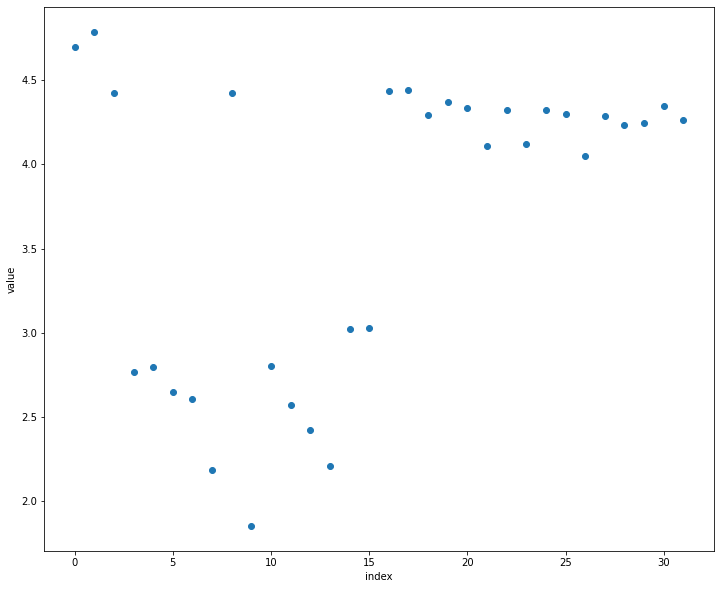

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Property Predictor

In [3]:
config = pickle.load(open('RUNS/2022-08-08@11:39:49-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()

Vocab created/loaded. Size: 70458. Effective size: 70458. Time elapsed: 00:00:00.


In [4]:
trainer = Trainer(config, vocab)
mu_stack, data_index_lst_final = trainer.train(dataset.get_loader(), 0)

Data loaded. Size: 62961. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batch  0  loss:  1160.3251953125
batch  1000  loss:  1044.2800403941762
tensor([[-0.0971,  0.2228,  0.1126,  ..., -0.1734,  0.1321, -0.0438],
        [ 0.0984,  0.0698,  0.0571,  ..., -0.1173,  0.0291,  0.0240],
        [ 0.0180,  0.1795,  0.1068,  ..., -0.2311,  0.1422, -0.0171],
        ...,
        [-0.0611,  0.2913, -0.0421,  ...,  0.0511,  0.1175, -0.0594],
        [-0.0783, -0.2119,  0.2113,  ..., -0.1053,  0.1030, -0.0937],
        [-0.1006,  0.2768, -0.2372,  ...,  0.0556, -0.1222, -0.0177]],
       grad_fn=<DivBackward0>)


In [5]:
dataset.data.iloc[data_index_lst_final]

,smiles,fragments,n_fragments,C,F,N,O,Other,SINGLE,DOUBLE,TRIPLE,Tri,Quad,Pent,Hex,logP,mr,qed,SAS
0,CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...,*CCC *N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O...,2,26,0,3,5,0,26,10,0,0,0,0,3,2.33400,128.6249,0.522569,3.595745
1,Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1,*c1ccc(O)cc1 *C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1,2,22,0,3,1,1,19,11,0,0,0,1,3,4.94030,112.9455,0.638566,2.563412
2,COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...,*C(=O)OC *CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c...,3,25,0,0,7,3,26,10,0,0,0,0,2,6.07540,138.1390,0.264467,2.973098
3,Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2c...,*c1cc(C)nc2ccccc12 *COc1ccc(NC(=O)C2CN(C)CCC2C...,2,25,0,4,4,0,26,10,0,0,0,0,4,3.13402,124.9069,0.395442,3.145495
4,CCOC(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C...,*OCC *C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)...,2,23,0,3,5,0,23,11,0,0,0,1,3,2.57720,116.8143,0.513201,2.494430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62956,O=C(NCc1ccc(S(=O)(=O)C2CCOCC2)cn1)c1cc2ccncc2s1,*C(=O)c1cc2ccncc2s1 *NCc1ccc(S(=O)(=O)C2CCOCC2...,2,19,0,3,4,2,21,10,0,0,0,1,3,2.57400,106.0540,0.685139,2.738054
62957,CCc1ncnc(NC(C)c2ccc(OC(=O)N(C)CCOCCN(C)C(C)=O)...,*c1ncnc(CC)c1Cl *NC(C)c1ccc(O*)cc1 *C(=O)N(C)C...,3,23,0,5,4,1,26,8,0,0,0,0,2,3.79100,127.6837,0.491513,3.250912
62958,CC(N)CCCNCCCN,*CCCC(C)N *NCCCN,2,8,0,3,0,0,10,0,0,0,0,0,0,0.05220,49.4245,0.459970,2.728956
62959,Cc1ccc(OP(=O)(Oc2ccc(C)cc2)C(=O)Oc2ccccc2)cc1,*c1ccc(C)cc1 *OP(=O)(Oc1ccc(C)cc1)C(=O)Oc1ccccc1,2,21,0,0,5,1,18,11,0,0,0,0,3,6.15334,103.6865,0.478347,2.289828


In [7]:
mu_stack

tensor([[ 0.0067, -0.0144, -0.1148,  ..., -0.0325, -0.0852, -0.0846],
        [ 0.0534,  0.0270, -0.0118,  ...,  0.1562, -0.0896, -0.0595],
        [ 0.0279, -0.0495, -0.1542,  ..., -0.0271, -0.0389, -0.0523],
        ...,
        [ 0.0177, -0.0095, -0.0418,  ...,  0.0014, -0.0338, -0.0226],
        [-0.0008, -0.0250,  0.0761,  ...,  0.0043, -0.0216, -0.0330],
        [ 0.0212, -0.0113, -0.0661,  ...,  0.0016, -0.0261, -0.0092]],
       grad_fn=<CatBackward0>)

In [7]:
F.normalize(mu_stack)

tensor([[-0.0971,  0.2228,  0.1126,  ..., -0.1734,  0.1321, -0.0438],
        [ 0.0984,  0.0698,  0.0571,  ..., -0.1173,  0.0291,  0.0240],
        [ 0.0180,  0.1795,  0.1068,  ..., -0.2311,  0.1422, -0.0171],
        ...,
        [-0.0611,  0.2913, -0.0421,  ...,  0.0511,  0.1175, -0.0594],
        [-0.0783, -0.2119,  0.2113,  ..., -0.1053,  0.1030, -0.0937],
        [-0.1006,  0.2768, -0.2372,  ...,  0.0556, -0.1222, -0.0177]],
       grad_fn=<DivBackward0>)